In [2]:
# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [3]:
# Read in the surveys

In [4]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

In [5]:
# Add DBN columns

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

In [7]:
# Convert columns to numeric

In [8]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

In [9]:
# Condense datasets

In [10]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

In [11]:
# Convert AP scores to numeric

In [12]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

In [13]:
# Combine the datasets

In [14]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

In [15]:
# Add a school district column for mapping

In [16]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

In [17]:
# Find correlations

In [18]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [19]:
# Set up matplotlib to work in Jupyter notebook.

In [61]:
%matplotlib inline
import matplotlib as plt
import math

In [115]:
fieldsSelected = correlations.loc[survey_fields]

rr_s
rr_t
rr_p
N_s
N_t
N_p
saf_p_11
com_p_11
eng_p_11
aca_p_11
saf_t_11
com_t_11
aca_t_11
saf_s_11
com_s_11
eng_s_11
aca_s_11
saf_tot_11
com_tot_11
eng_tot_11
aca_tot_11


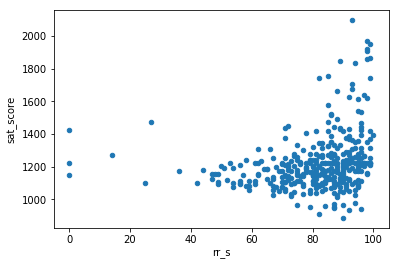

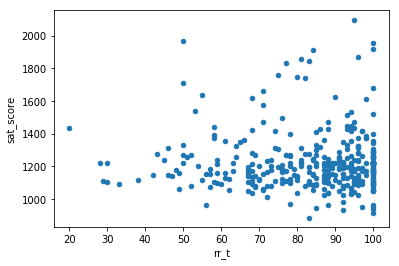

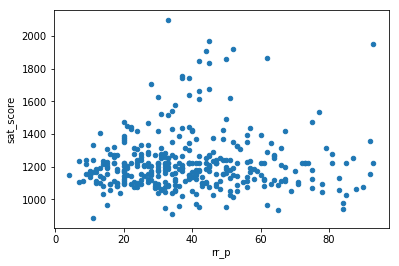

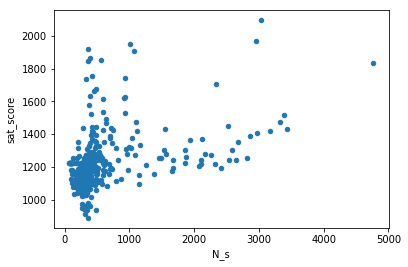

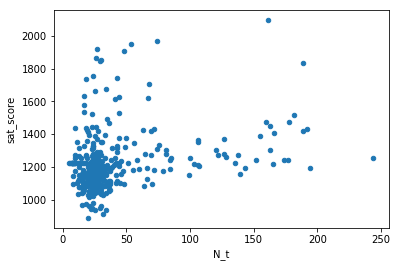

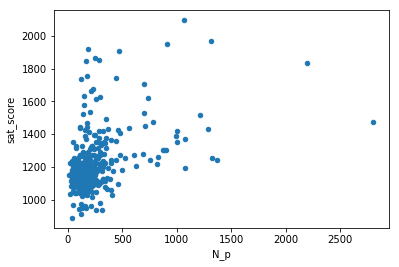

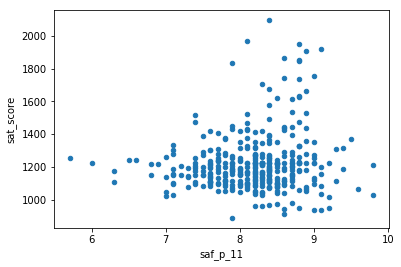

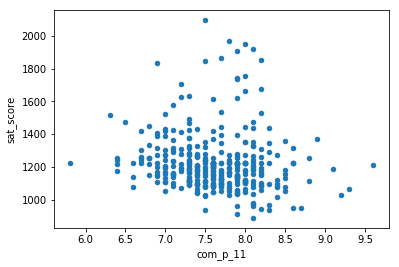

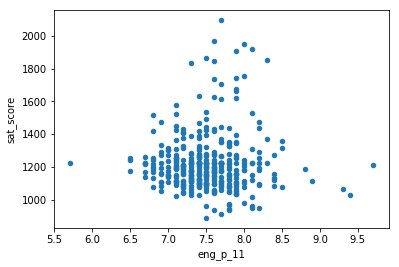

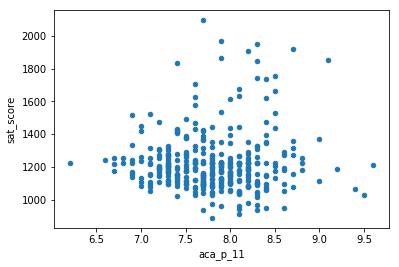

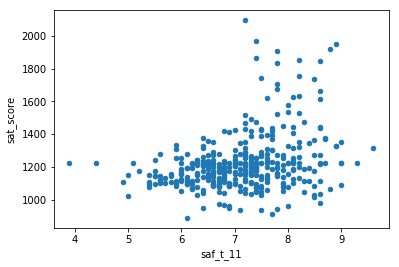

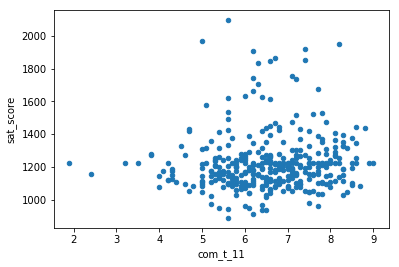

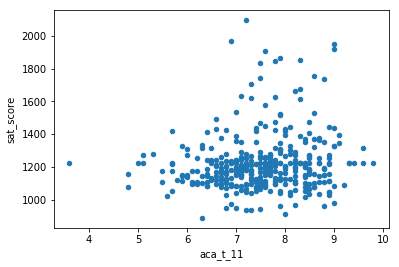

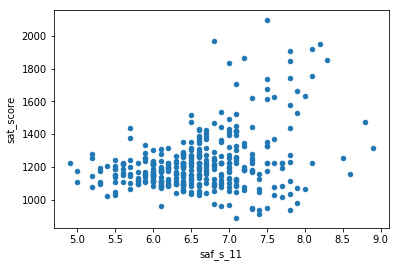

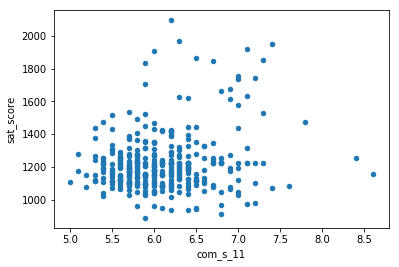

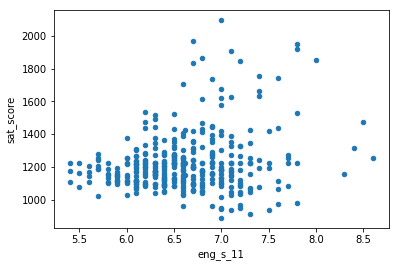

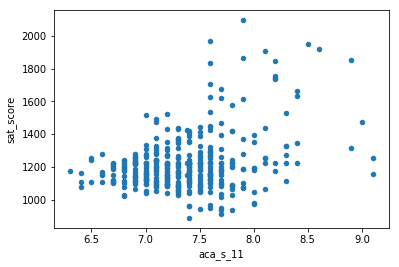

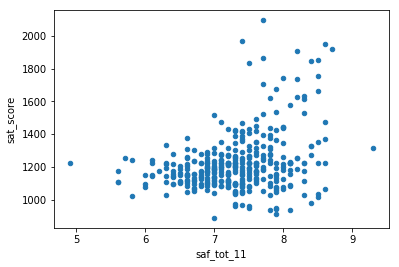

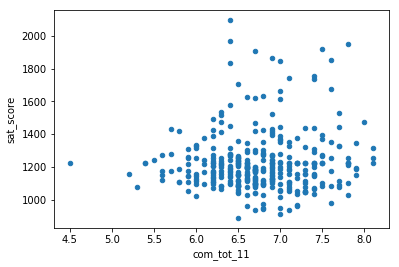

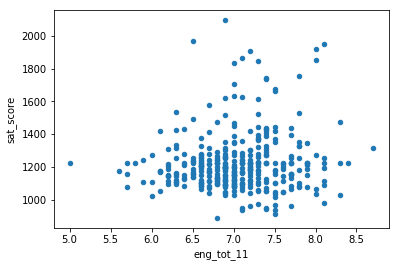

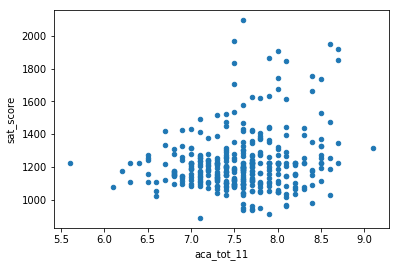

In [116]:
for field in survey_fields:
    if not(math.isnan(fieldsSelected[field])):
        print(field)
        combined.plot.scatter(x=field, y="sat_score")

In [132]:
# upper than .25 and lower than -.25

combined.corr()["sat_score"][survey_fields]

DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_10           NaN
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64

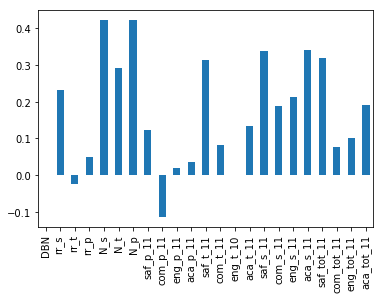

In [130]:
combined.corr()["sat_score"][survey_fields].plot.bar()

In [117]:
# 2

# Investigate safety scores.
# Make a scatter plot of the saf_s_11 column vs. the sat_score in combined.
# Write up your conclusions about safety and SAT scores in a Markdown cell.
# Map out safety scores.
# Compute the average safety score for each district.
# Make a map that shows safety scores by district.
# Write up your conclusions about safety by geographic area in a Markdown cell. You may want to read up on the boroughs of New York City.

# Conclusion about low sat score and student understanding about safety

- Almost all students that took lower than 1600 on sat score feels lower than 8.0 the safety.

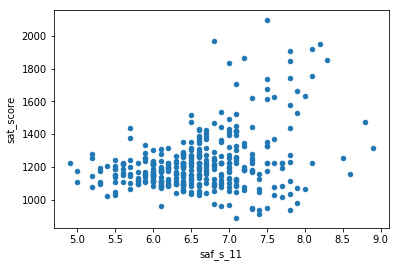

In [118]:
combined.plot.scatter(x="saf_s_11", y="sat_score")

# Compute the average safety score for each district

In [128]:
import numpy

districts = combined.groupby('school_dist').aggregate(numpy.mean)
districts.reset_index(inplace=True)
districts[["saf_s_11","school_dist"]].head(120)

,saf_s_11,school_dist
0,6.768611,01
1,6.910660,02
2,6.716667,03
3,6.885714,04
4,6.314286,05
5,6.950000,06
6,6.800000,07
7,6.364697,08
8,6.655000,09
9,6.577273,10


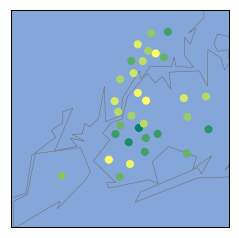

In [134]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts["lon"].values
latitudes = districts["lat"].values

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="summer")

plt.show()

In [136]:
# 3

# Investigate racial differences in SAT scores.
# Make a bar plot of the correlations between the columns above and sat_score.
# Write up a Markdown cell containing your findings. Are there any unexpected correlations?
# Explore schools with low SAT scores and high values for hispanic_per.
# Make a scatter plot of hispanic_per vs. sat_score.
# What does the scatter plot show? Record any interesting observsations in a Markdown cell.
# Research any schools with a hispanic_per greater than 95%.
# Find the school names in the data.
# Use Wikipedia and Google to research the schools by name.
# Is there anything interesting about these particular schools? Record your findings in a Markdown cell.
# Research any schools with a hispanic_per less than 10% and an average SAT score greater than 1800.
# Find the school names in the data.
# Use Wikipedia and Google to research the schools by name.
# Is there anything interesting about these particular schools? Record your findings in a Markdown cell.


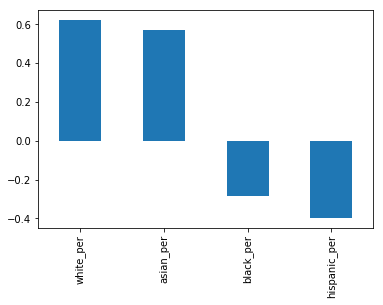

In [135]:
racialColumns = ["white_per", "asian_per", "black_per", "hispanic_per"]

correlations[racialColumns].plot.bar()

- It looks `white` and `asian` have correlation with the sat score.
- It looks `black` and `hispanic` have an inverse correlation with the sat score.

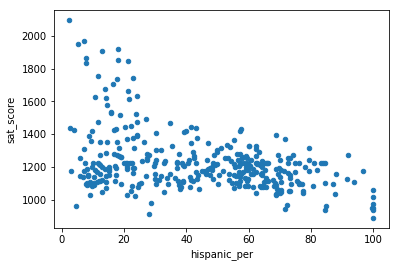

In [137]:
combined.plot.scatter(x="hispanic_per", y="sat_score")

In [138]:
print(combined[combined["hispanic_per"] > 95]["SCHOOL NAME"])


44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [143]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [144]:
# 4

# Investigate gender differences in SAT scores.
# Make a bar plot of the correlations between the columns above and sat_score.
# Record your findings in a Markdown cell. Are there any unexpected correlations?
# Investigate schools with high SAT scores and a high female_per.
# Make a scatter plot of female_per vs. sat_score.
# What does the scatter plot show? Record any interesting observations in a Markdown cell.
# Research any schools with a female_per greater than 60% and an average SAT score greater than 1700.
# Find the school names in the data.
# Use Wikipedia and Google to research the schools by name.
# Is there anything interesting about these particular schools? Record your findings in a Markdown cell.



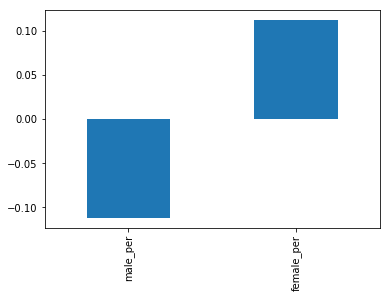

In [147]:
genderColumns = ["male_per", "female_per"]

correlations[genderColumns].plot.bar()

In [148]:
print(correlations[genderColumns])

male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


- Considering the level of correlation, it looks that the gender has no relation with the sat score.

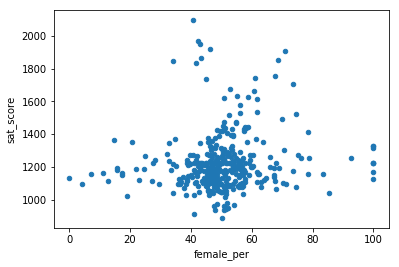

In [149]:
combined.plot.scatter("female_per", "sat_score")


In [150]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])


5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [151]:
# 5

# Calculate the percentage of students in each school that took an AP exam.
# Divide the AP Test Takers column by the total_enrollment column.
# The column name AP Test Takers has a space at the end -- don't forget to add it!
# Assign the result to the ap_per column.
# Investigate the relationship between AP scores and SAT scores.
# Make a scatter plot of ap_per vs. sat_score.
# What does the scatter plot show? Record any interesting observations in a Markdown cell.


# AP Exam Scores vs SAT Scores

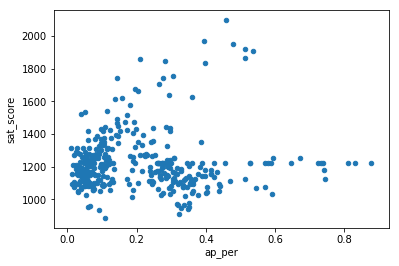

In [152]:
combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

combined.plot.scatter(x='ap_per', y='sat_score')